In [2]:
import timm
import os
import h5py
import numpy as np
import torch
from sklearn.model_selection import KFold
import warnings
import scipy
from scipy import stats 
from scipy.stats import shapiro
warnings.filterwarnings('ignore')
import os
import matplotlib.ticker as mtick
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

In [63]:
#按沟回划分
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    # data = np.arange(1,1008)
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)
    gyri_sulci_sub = np.array([1,2]*68+[3]*19)
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            # lobe = gyri_sulci_sub[top_node]
            one_fold_lobe.append(top_node)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)

In [64]:
#沟回的脑区数量,无特有共有
uniqiu_value = []
for task_ in range(7):
    for k in range(6):
        for j in range(5):
            task_unique = np.array([len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==1]),len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==2]),
            len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==3])])
            uniqiu_value.append(task_unique)      

In [65]:
#标准化后的结果
uniqiu_value = []
for task_ in range(7):
    for k in range(6):
        for j in range(5):
            all = [len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==1]),
            len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==2]),
            (68/19)*len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==3])]
            task_unique = np.array(all)
            task_unique = np.divide(task_unique, sum(all))
            uniqiu_value.append(task_unique)      

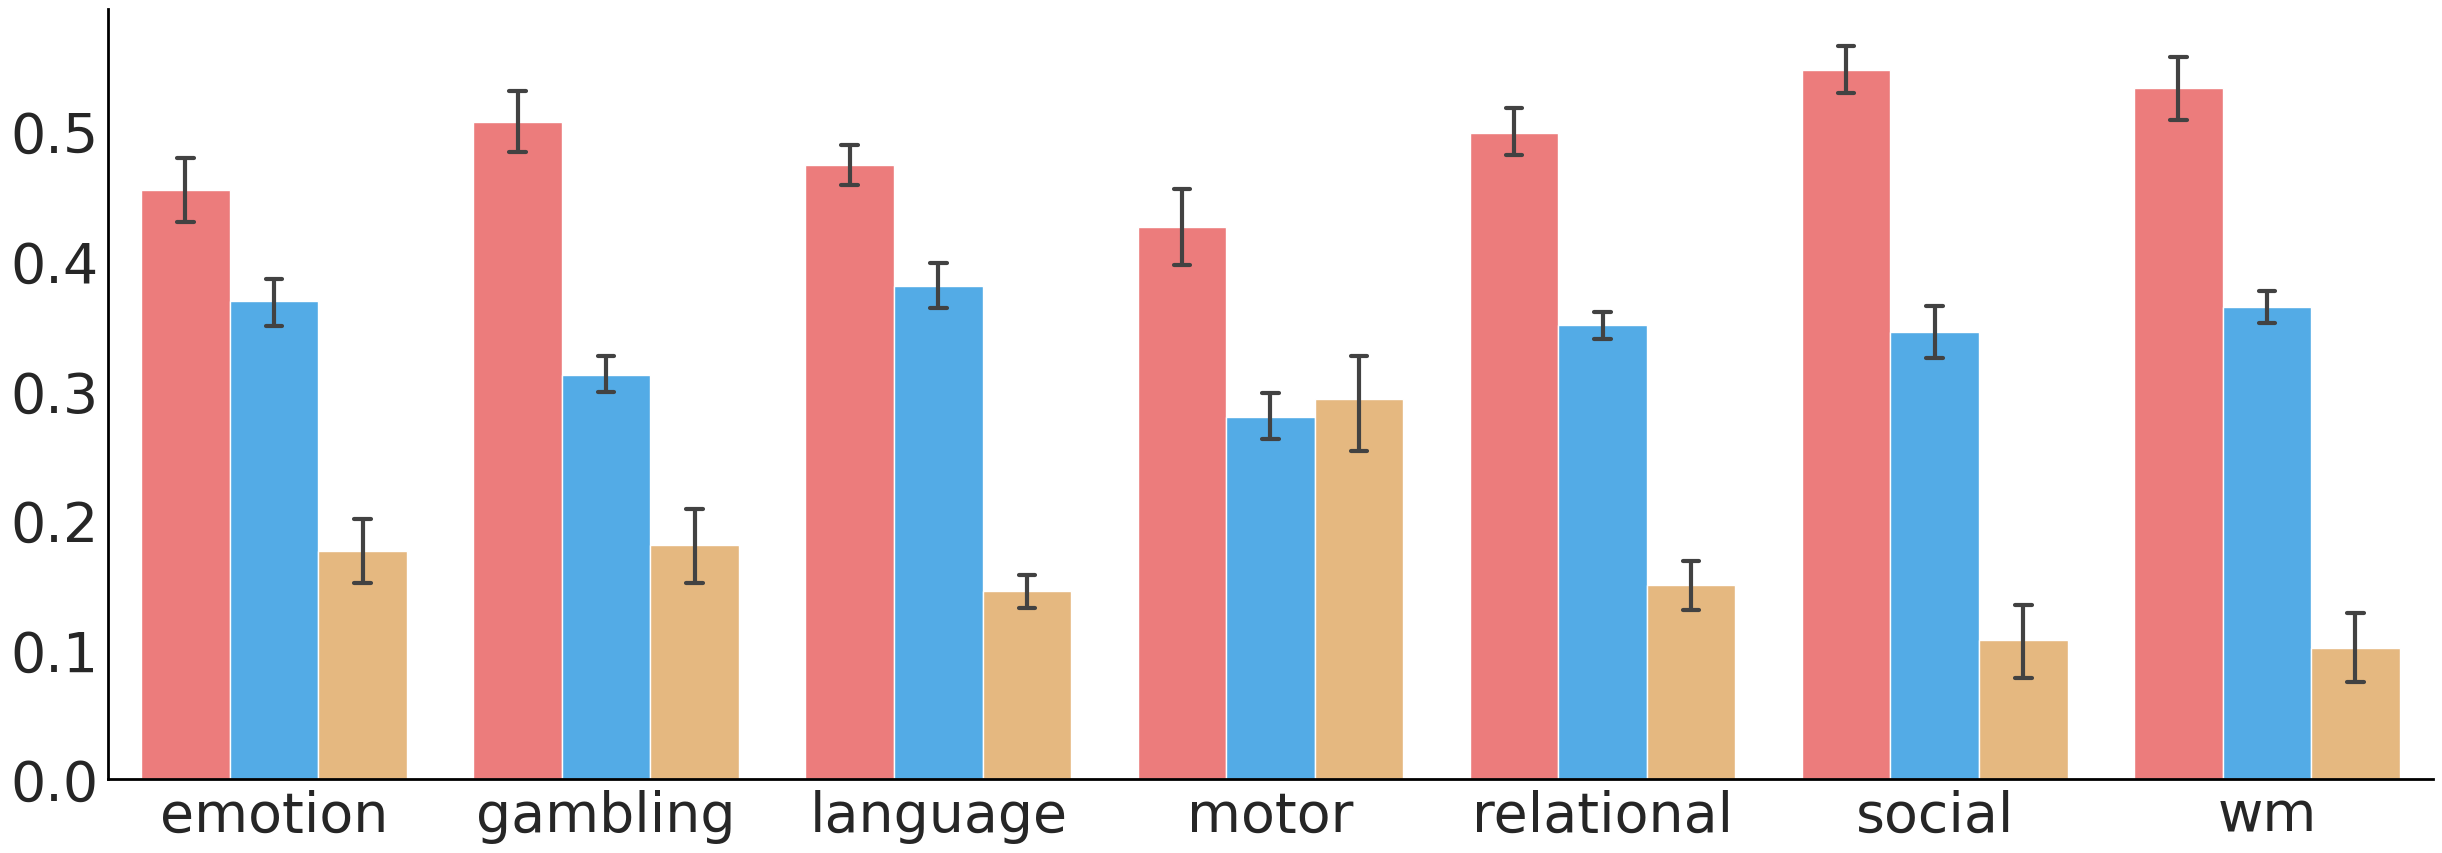

In [66]:
flatui = ["#FF6969", "#3AB0FF","#F6BA6F"  ]
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
# df.insert(loc=1, column='task', value=np.repeat(range(0,7), 90))
df.insert(loc=1, column='task', value=list(np.repeat(range(0,7), 90)))
df.insert(loc=2, column='gysulsub', value=list(np.arange(0,3))*210)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Sulci','Gyri','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm']
# task_type = ['emotion','gambling','language','motor','relational','social','wm']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%7]
for i in np.arange(0,len(graph_value['gysulsub'])):
    graph_value['gysulsub'][i] = six_regions_name[graph_value['gysulsub'][i]%3]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['gysulsub'],
                 palette = sns.color_palette(flatui),errwidth=3,capsize=0.05,ci = 95)
ax.get_legend().remove()
plt.ylabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.xlabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/3parts/dk_chcp.svg".format(percent), dpi=300,format="svg")

In [403]:
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
df.insert(loc=1, column='gysulsub', value=list(np.arange(0,3))*210)
six_regions_name = ['Sulci','Gyri','Subcortical']
# task_type = ['emotion','gambling','language','motor','relational','social','wm']            
graph_value = df
for i in np.arange(0,len(graph_value['gysulsub'])):
    graph_value['gysulsub'][i] = six_regions_name[graph_value['gysulsub'][i]%3]   
for i in range(6,7):
    model = ols('value ~C(gysulsub)', data = graph_value[i*90:(i+1)*90]).fit()
    anova_table = anova_lm(model, type = 2)
    print(pd.DataFrame(anova_table))

# 进行事后比较分析
print(pairwise_tukeyhsd(graph_value[i*90:(i+1)*90]['value'], graph_value[i*90:(i+1)*90]['gysulsub']))

               df    sum_sq   mean_sq           F        PR(>F)
C(gysulsub)   2.0  1.110326  0.555163  122.077915  5.593425e-26
Residual     87.0  0.395642  0.004548         NaN           NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
       Gyri Subcortical   -0.183   0.0 -0.2245 -0.1414   True
       Gyri       Sulci   0.0829   0.0  0.0414  0.1244   True
Subcortical       Sulci   0.2659   0.0  0.2243  0.3074   True
-------------------------------------------------------------


In [10]:
#按沟回划分
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
# data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
# data = [int(i[0:4]) for i in data]
# data = np.array(sorted(data))
data = np.arange(1,1008)
for random_state_num in range(1998,2004):
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)
    gyri_sulci_sub = np.array([1,2]*68+[3]*19)
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            # lobe = gyri_sulci_sub[top_node]
            one_fold_lobe.append(top_node)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)

In [11]:
#沟回的脑区数量，有特有独有
uniqiu_value = []
for k in range(6):
    for j in range(5):
        comm = all_lobe[k][j][0]
        for task in range(7):
            comm = np.intersect1d(all_lobe[k][j][task],comm)
        comm_lobe = gyri_sulci_sub[comm]
        lobe_value = [len([i for i in comm_lobe if i==1]),len([i for i in comm_lobe if i==2]),
                len([i for i in comm_lobe if i==3])]
        for task_ in range(7):
            task_unique = np.array([len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==1]),len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==2]),
            len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==3])])-np.array(lobe_value)
            uniqiu_value.append(task_unique)      
        uniqiu_value.append(lobe_value)

In [12]:
#标准化后的结果
uniqiu_value = []
for k in range(6):
    for j in range(5):
        comm = all_lobe[k][j][0]
        for task in range(7):
            comm = np.intersect1d(all_lobe[k][j][task],comm)
        comm_lobe = gyri_sulci_sub[comm]
        lobe_value = [len([i for i in comm_lobe if i==1]),
        len([i for i in comm_lobe if i==2]),
        (68/19)*len([i for i in comm_lobe if i==3])]
        for task_ in range(7):
            all = [len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==1]),
            len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==2]),
            (68/19)*len([i for i in gyri_sulci_sub[all_lobe[k][j][task_]] if i==3])]
            task_unique = np.array(all)-np.array(lobe_value)
            task_unique = np.divide(task_unique, sum(all))
            uniqiu_value.append(task_unique)      
        uniqiu_value.append(np.divide(lobe_value, sum(all)))

In [34]:
np.array(uniqiu_value).shape

(240, 3)

In [ ]:
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
df.insert(loc=1, column='task', value=list(np.repeat(range(0,8), 3))*30)
df.insert(loc=2, column='gysulsub', value=list(np.arange(0,3))*240)
six_regions_name = ['Sulci','Gyri','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm','common region']               
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%8]
for i in np.arange(0,len(graph_value['gysulsub'])):
    graph_value['gysulsub'][i] = six_regions_name[graph_value['gysulsub'][i]%3] 

for i in range(7,8):
    model = ols('value ~C(gysulsub)', data = graph_value[graph_value['task']==task_type[i]]).fit()
    anova_table = anova_lm(model, type = 2)
    print(pd.DataFrame(anova_table))

# 进行事后比较分析
print(pairwise_tukeyhsd(graph_value[graph_value['task']==task_type[i]]['value'], graph_value[graph_value['task']==task_type[i]]['gysulsub']))

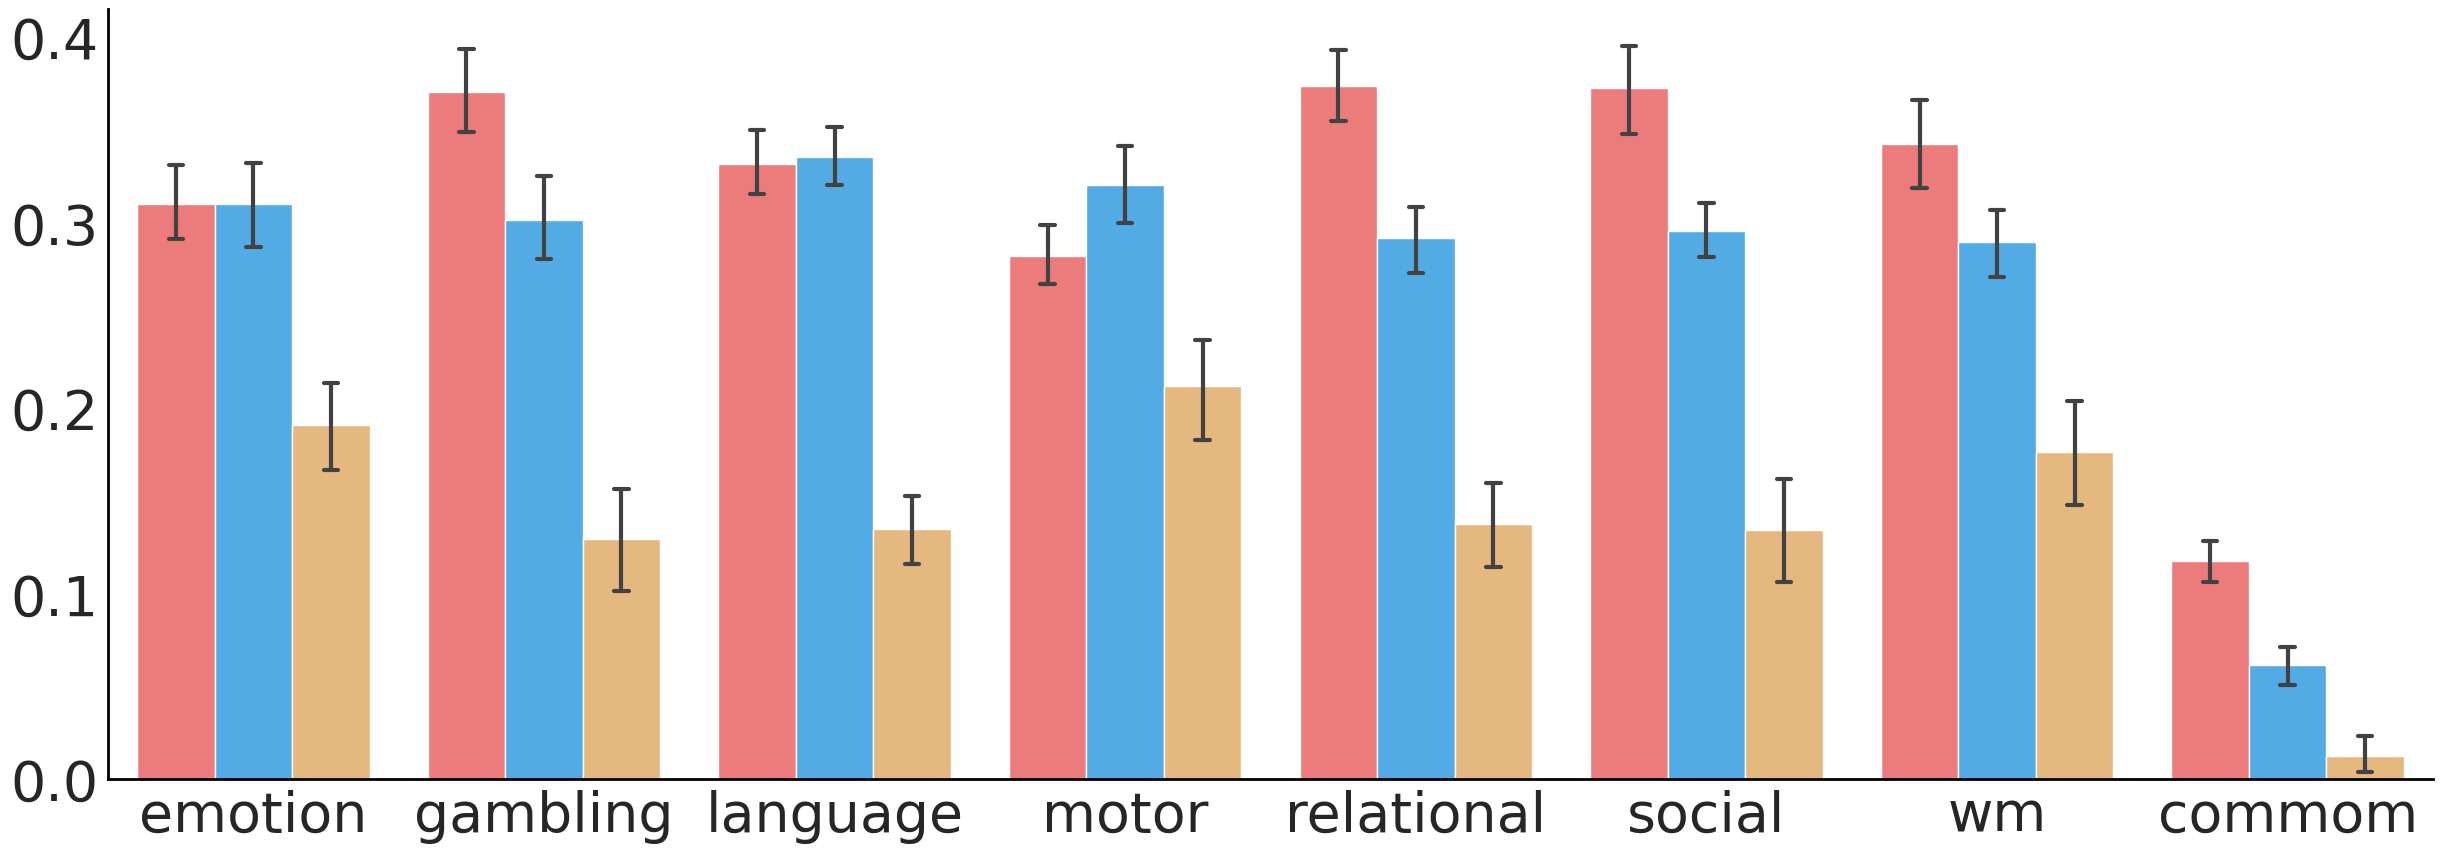

In [16]:
flatui = ["#FF6969", "#3AB0FF","#F6BA6F"  ]
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
# df.insert(loc=1, column='task', value=np.repeat(range(0,7), 90))
df.insert(loc=1, column='task', value=list(np.repeat(range(0,8), 3))*30)
df.insert(loc=2, column='gysulsub', value=list(np.arange(0,3))*240)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Sulci','Gyri','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm','commom']
# task_type = ['emotion','gambling','language','motor','relational','social','wm']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%8]
for i in np.arange(0,len(graph_value['gysulsub'])):
    graph_value['gysulsub'][i] = six_regions_name[graph_value['gysulsub'][i]%3]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['gysulsub'],
                 palette = sns.color_palette(flatui),errwidth=3,capsize=0.05,ci = 95)
ax.get_legend().remove()
plt.ylabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.xlabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax = plt.gca()
y_major_locator=MultipleLocator(0.1)
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/hcp/815/{}_top30_common_unique.svg".format(percent), dpi=300,format="svg")

In [35]:
# 从15到80的数据的一致性，沟回皮下
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 30
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)

    gyri_sulci_sub = np.array([1,2]*68+[3]*19)
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            one_task = []
            for max_node in np.arange(15,79):
                top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:max_node]
                lobe = gyri_sulci_sub[top_node]
                lobe_value = [len([i for i in lobe if i==1]),len([i for i in lobe if i==2]),
                (68/19)*len([i for i in lobe if i==3])]
                one_task.append(np.divide(lobe_value, sum(lobe_value)))
            # lobe_value = [len([i for i in lobe if i==1]),len([i for i in lobe if i==2]),
            # len([i for i in lobe if i==3])
            # ,len([i for i in lobe if i==4]),len([i for i in lobe if i==5]),len([i for i in lobe if i==6])]
            one_fold_lobe.append(one_task)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)
aaa = np.array(all_lobe).transpose(2,4,3,0,1).reshape(7,3,64,30)

In [ ]:
for i in range(4,5):
    model = ols('value ~C(gysulsub)', data = graph_value[graph_value['task']==task_type[i]]).fit()
    anova_table = anova_lm(model, type = 2)
    print(pd.DataFrame(anova_table))

# 进行事后比较分析
print(pairwise_tukeyhsd(graph_value[graph_value['task']==task_type[i]]['value'], graph_value[graph_value['task']==task_type[i]]['gysulsub']))

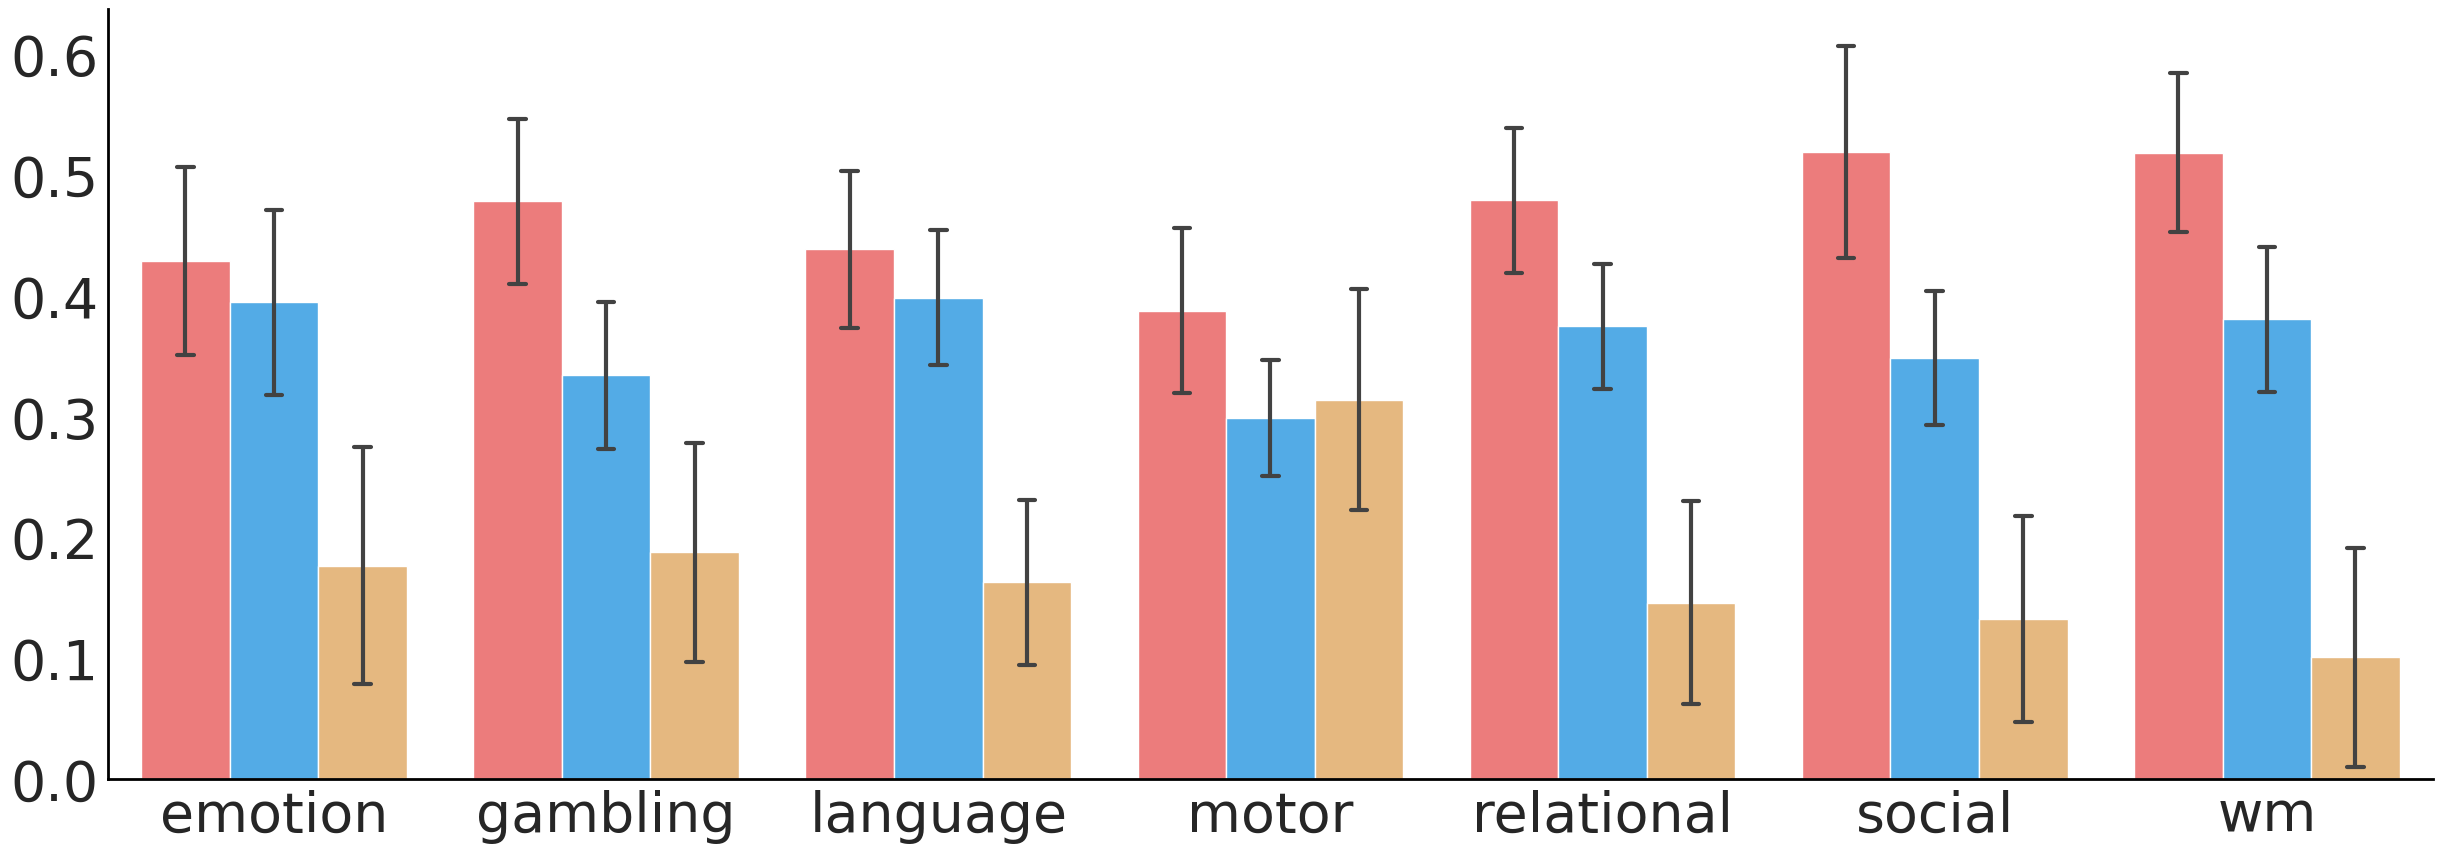

In [36]:
column = ['value']
df = pd.DataFrame(columns=column,data = aaa.reshape(-1))
df.insert(loc=1, column='gysulsub', value=list(np.repeat(range(0,3),64*30))*7)
df.insert(loc=1, column='task', value=np.repeat(range(7),3*64*30))
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Sulci','Gyri','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm']
# task_type = ['emotion','gambling','language','motor','relational','social','wm']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%7]
for i in np.arange(0,len(graph_value['gysulsub'])):
    graph_value['gysulsub'][i] = six_regions_name[graph_value['gysulsub'][i]%3]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['gysulsub'],palette = sns.color_palette(flatui),ci='sd',errwidth=3,capsize=0.05)
ax.get_legend().remove()
plt.ylabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.xlabel('',fontdict={'family' : 'Arial', 'size'   : 30})
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/topgyrisulci/all_{}percent.svg".format(percent), dpi=300,format="svg")

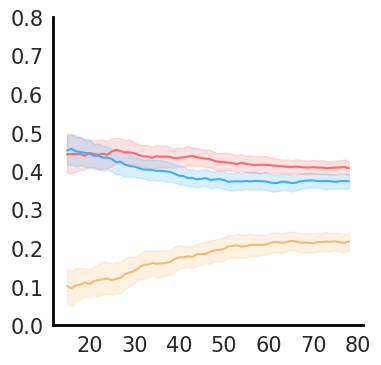

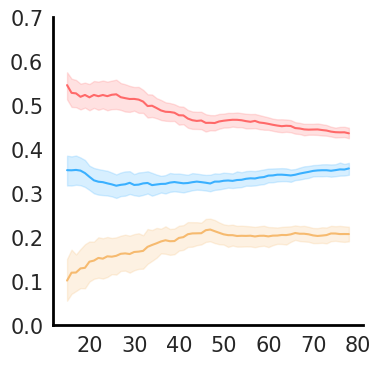

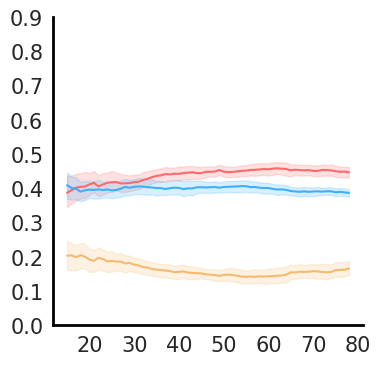

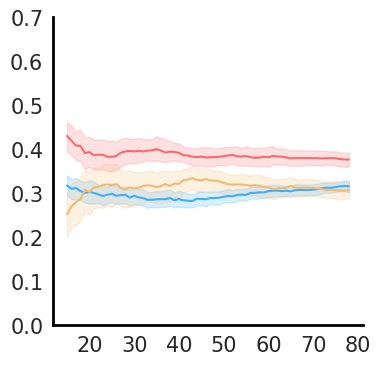

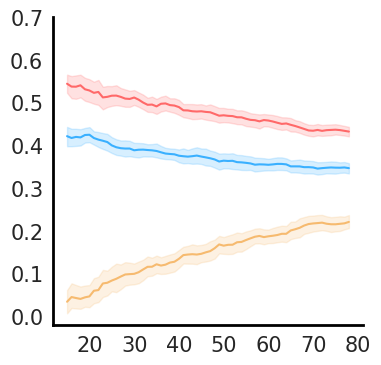

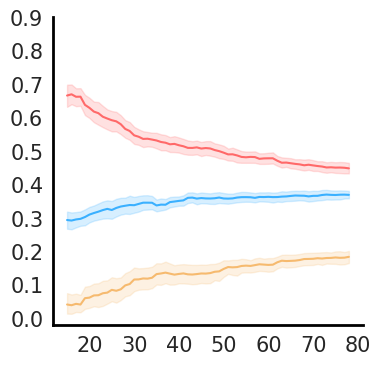

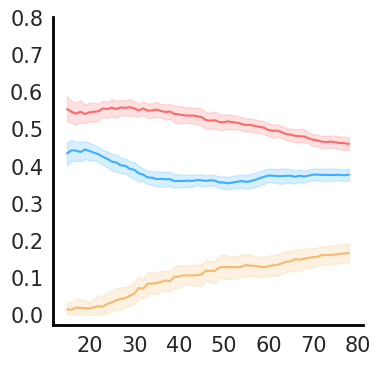

In [37]:
#0000CC  #C90000    #FFFF00
flatui = ["#FF6969", "#3AB0FF","#F6BA6F"  ]
for task_now in range(7):
    column = ['value']
    df = pd.DataFrame(columns=column,data = aaa[task_now].reshape(-1))
    df.insert(loc=1, column='lobe', value=np.repeat(range(0,3), 64*30))
    df.insert(loc=1, column='node_num', value=list(np.repeat(range(15,79),30))*3)
    sns.set_style("whitegrid", {'axes.grid' : False})
    six_regions_name = ['Sulci','Gyri','Subcortical']
    fig,ax = plt.subplots(figsize=(4,4))                
    graph_value = df
    for i in np.arange(0,len(graph_value['lobe'])):
        graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%3]    
    ax = sns.lineplot( x=graph_value["node_num"],y=graph_value["value"],hue=graph_value['lobe'],palette = sns.color_palette(flatui))
    ax.get_legend().remove()
    max_num = round(max(aaa[task_now].reshape(-1))*10)/10
    plt.ylabel('',fontsize=40)
    plt.xlabel('',fontsize=30,weight='bold')
    plt.yticks(np.arange(0,max_num+0.1,0.1),fontsize=15)
    plt.xticks(fontsize=15)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/topgyrisulci/{}_{}.svg".format(percent,CLS2IDX[task_now]), dpi=300,format="svg")

In [76]:
# six lobe
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    # data = np.arange(1,1008)
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                # sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_vis/{}/{}/{}_node_{}_7class_original.npy'
                # .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)

    # six_lobe = np.load('/media/D/zephyr/vit_155_155/other_map/scheafer_lobe.npy')
    six_lobe = np.load('/media/D/zephyr/vit_155_155/tulunzhibiao/bigger_six_region_of_155_region.npy')
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            lobe = six_lobe[top_node]
            lobe_value = [len([i for i in lobe if i==1]),
            (40/24)*len([i for i in lobe if i==2]),
            (40/28)*len([i for i in lobe if i==3]),
            (40/24)*len([i for i in lobe if i==4]),
            (40/20)*len([i for i in lobe if i==5]),
            (40/19)*len([i for i in lobe if i==6])]

            # lobe_value = [len([i for i in lobe if i==1]),len([i for i in lobe if i==2]),
            # len([i for i in lobe if i==3])
            # ,len([i for i in lobe if i==4]),len([i for i in lobe if i==5]),len([i for i in lobe if i==6])]
            one_fold_lobe.append(np.divide(lobe_value, sum(lobe_value)))
            # one_fold_lobe.append(lobe_value)
            # one_fold_lobe.append(lobe_value)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)


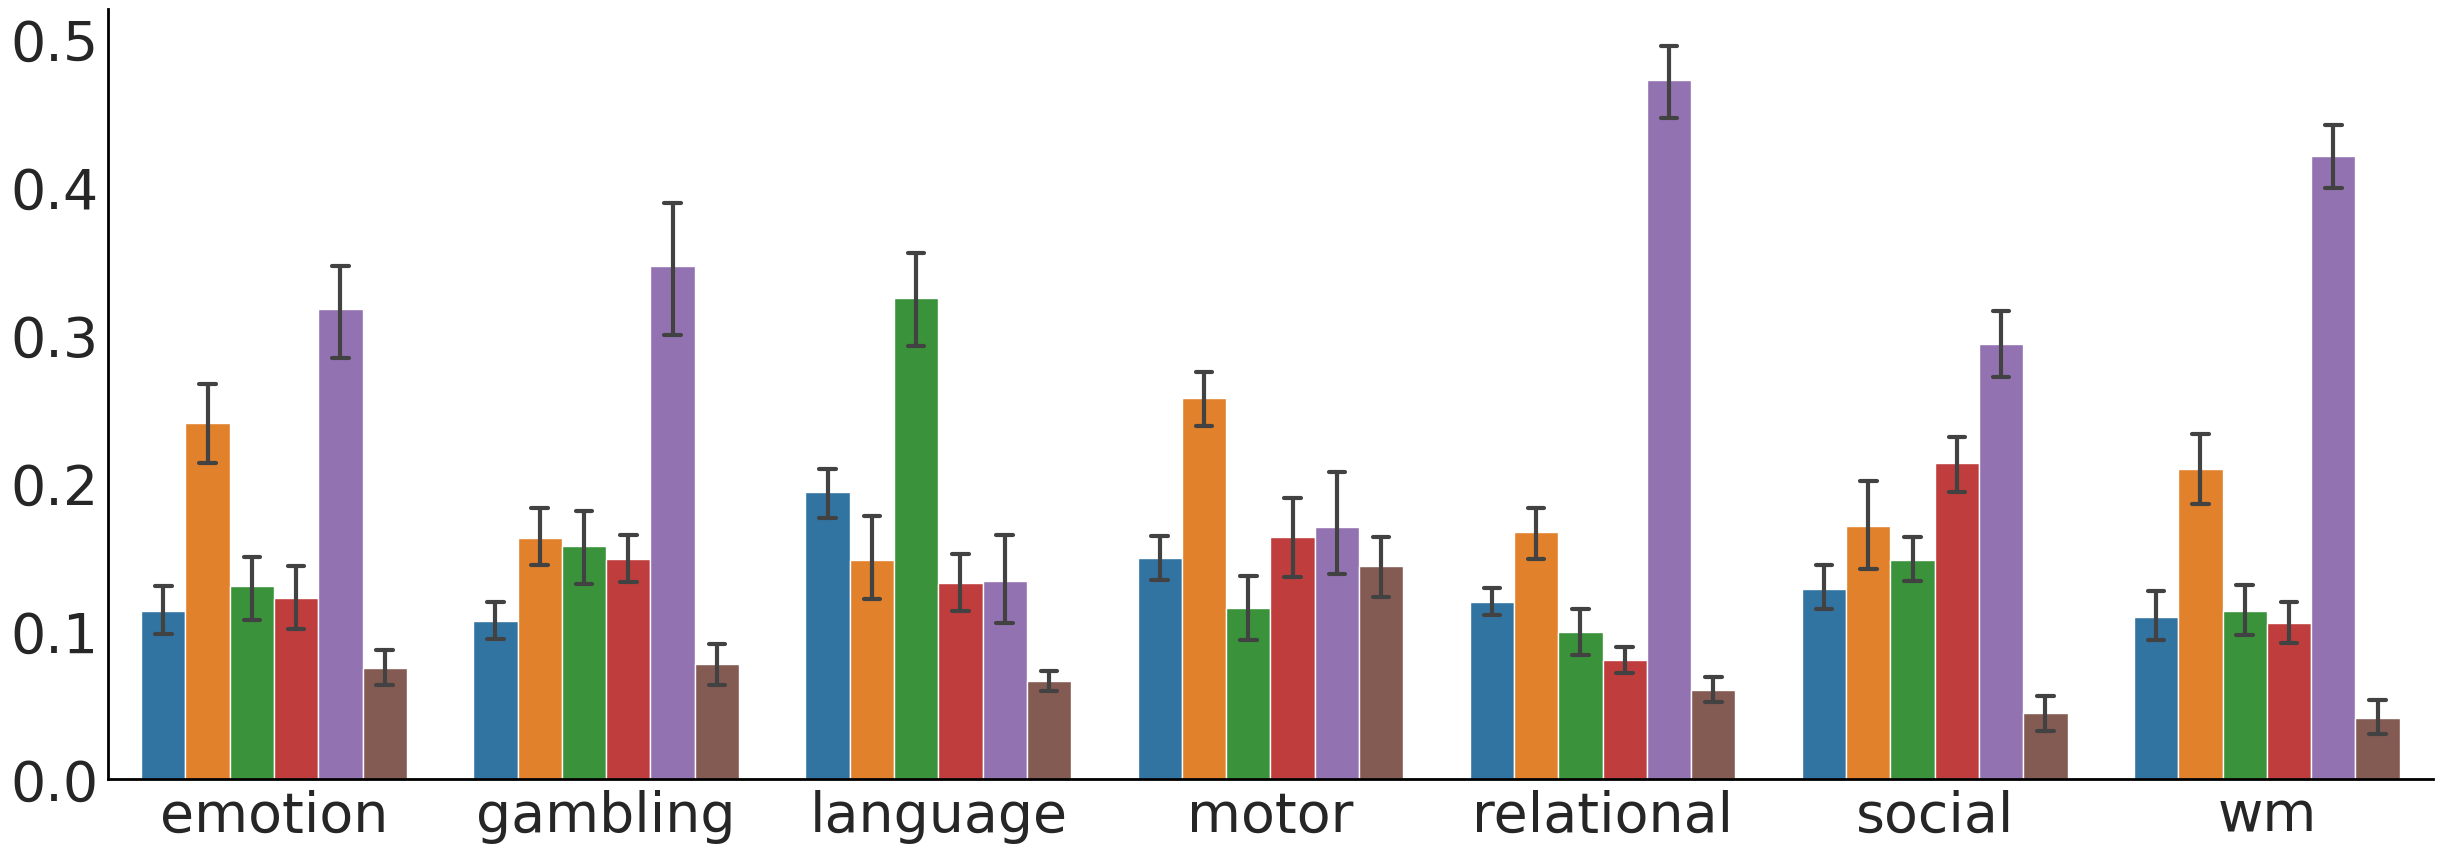

In [77]:
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(all_lobe).reshape(30,7,6).transpose(1,2,0).reshape(-1))
df.insert(loc=1, column='task', value=np.repeat(range(0,7), 180))
df.insert(loc=2, column='lobe', value=list(np.repeat(range(0,6), 30))*7)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Frontal','Limbic','Temporal','Parietal','Occipital','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%7]
for i in np.arange(0,len(graph_value['lobe'])):
    graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%6]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['lobe'],errwidth=3,capsize=0.05,ci=95)
ax.get_legend().remove()
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
y_major_locator=MultipleLocator(0.1)
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/6parts/chcp_dk.svg".format(percent), dpi=300,format="svg")

In [56]:
# 从15到80的数据的一致性
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 30
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
for random_state_num in range(1998,2004):
    # data = np.arange(1,1008)
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)

    six_lobe = np.load('/media/D/zephyr/vit_155_155/tulunzhibiao/bigger_six_region_of_155_region.npy')
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            one_task = []
            for max_node in np.arange(15,79):
                top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:max_node]
                lobe = six_lobe[top_node]
                lobe_value = [len([i for i in lobe if i==1]),
                (40/24)*len([i for i in lobe if i==2]),
                (40/28)*len([i for i in lobe if i==3]),
                (40/24)*len([i for i in lobe if i==4]),
                (40/20)*len([i for i in lobe if i==5]),
                (40/19)*len([i for i in lobe if i==6])]
                one_task.append(np.divide(lobe_value, sum(lobe_value)))
                # one_task.append(lobe_value)
            # lobe_value = [len([i for i in lobe if i==1]),len([i for i in lobe if i==2]),
            # len([i for i in lobe if i==3])
            # ,len([i for i in lobe if i==4]),len([i for i in lobe if i==5]),len([i for i in lobe if i==6])]
            one_fold_lobe.append(one_task)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)
aaa = np.array(all_lobe).transpose(2,4,3,0,1).reshape(7,6,64,30)

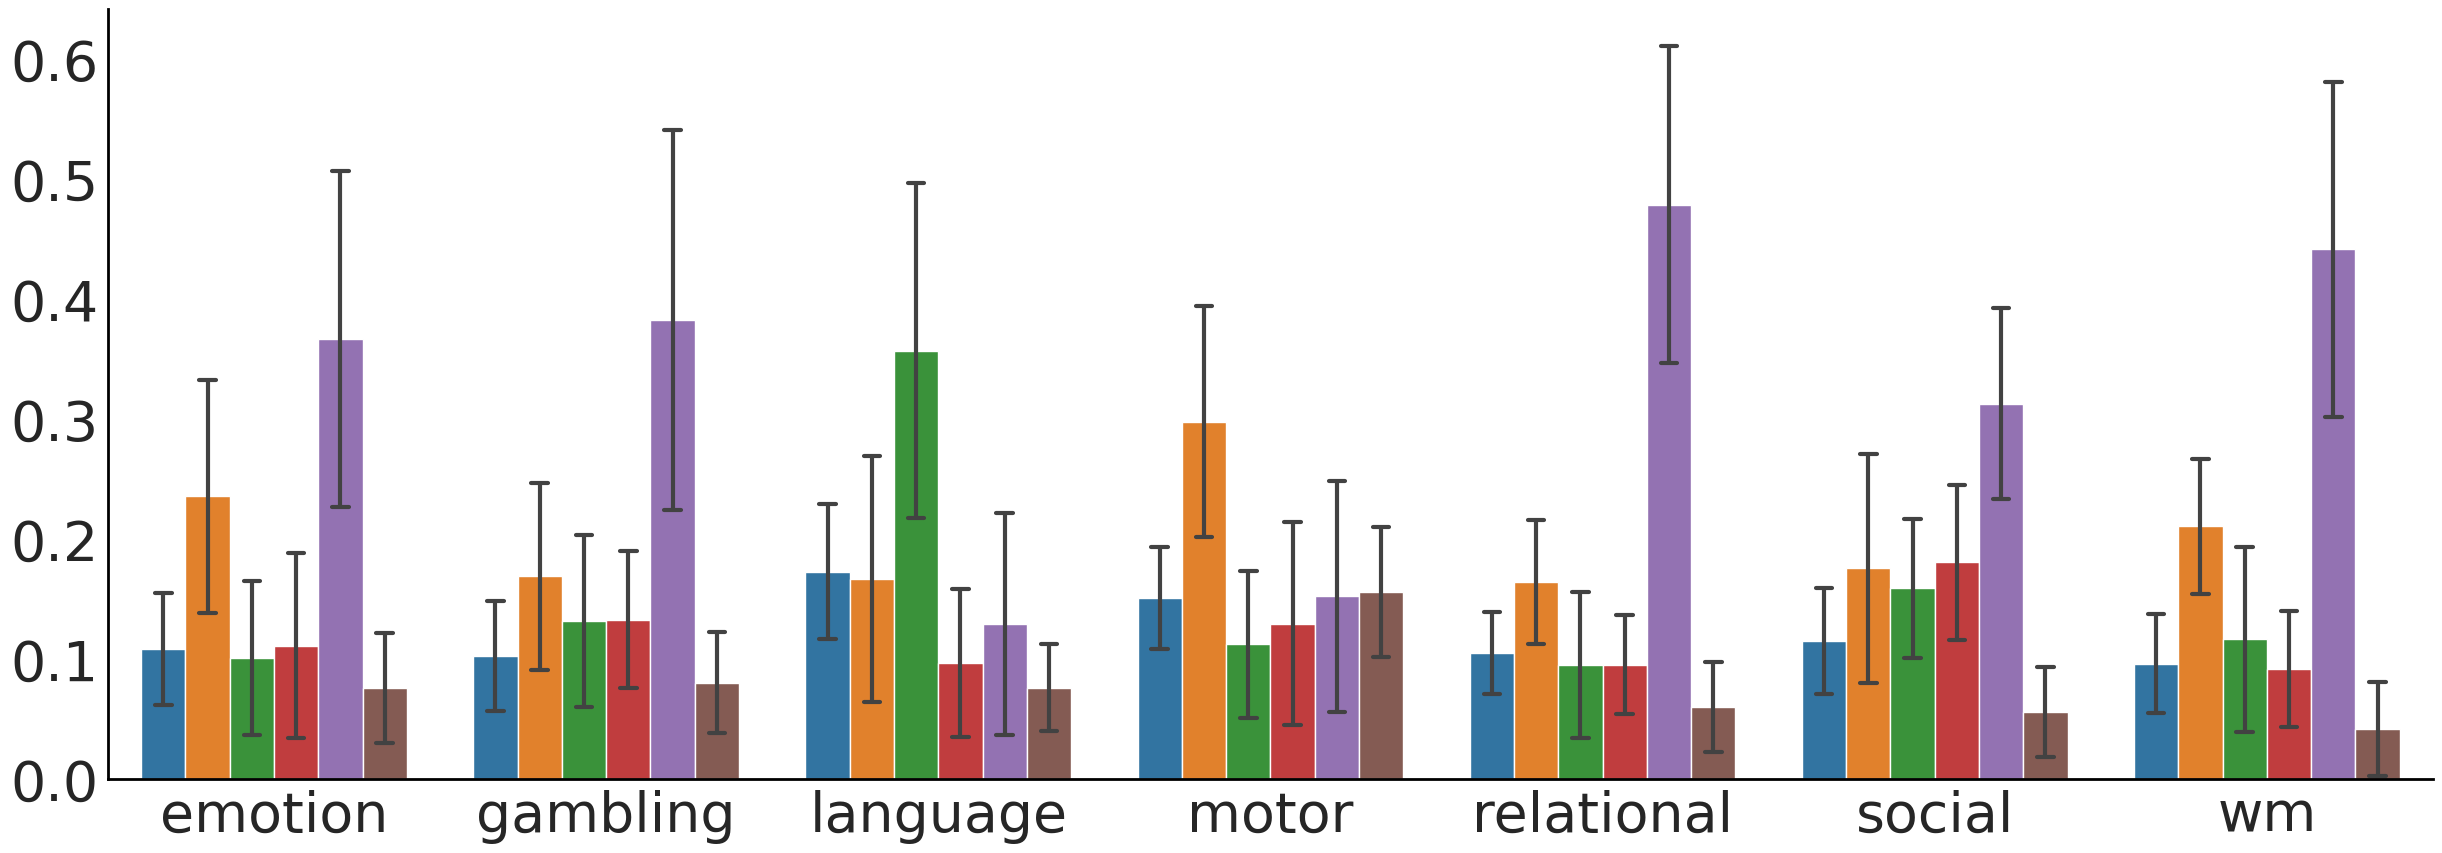

In [57]:
column = ['value']
df = pd.DataFrame(columns=column,data = aaa.reshape(-1))
df.insert(loc=1, column='task', value=np.repeat(range(0,7), 64*30*6))
df.insert(loc=2, column='lobe', value=list(np.repeat(range(0,6), 64*30))*7)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Frontal','Limbic','Temporal','Parietal','Occipital','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%7]
for i in np.arange(0,len(graph_value['lobe'])):
    graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%6]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['lobe'],ci='sd',errwidth=3,capsize=0.05)
ax.get_legend().remove()
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/important_region/{}_all_std_10_50.svg".format(percent), dpi=300,format="svg")

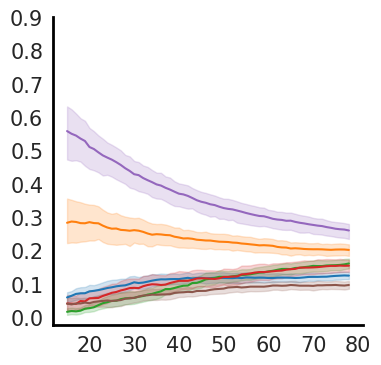

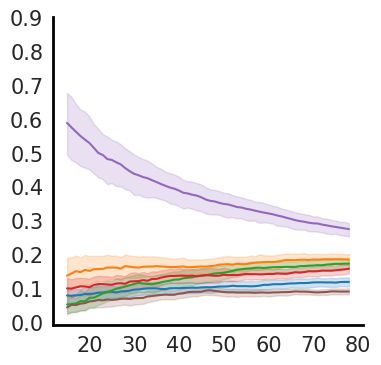

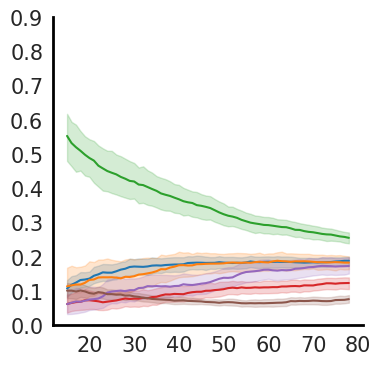

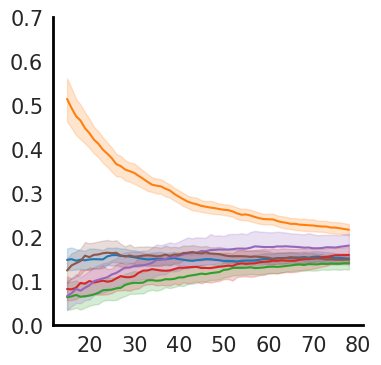

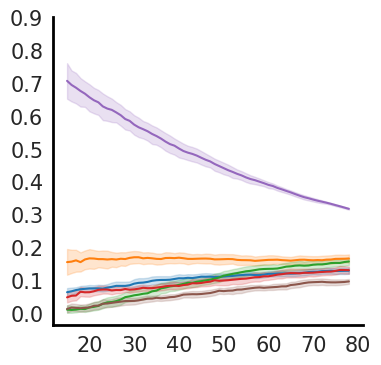

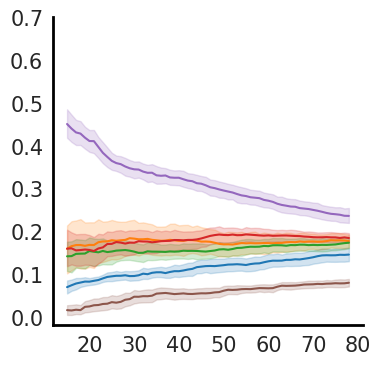

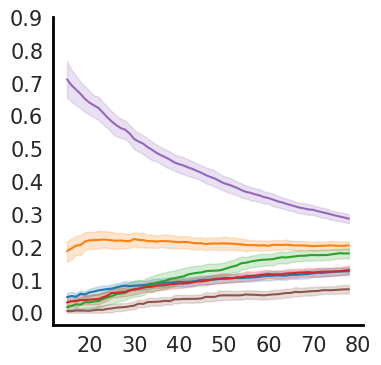

In [58]:
for task_now in range(7):
    column = ['value']
    df = pd.DataFrame(columns=column,data = aaa[task_now].reshape(-1))
    df.insert(loc=1, column='lobe', value=np.repeat(range(0,6), 64*30))
    df.insert(loc=1, column='node_num', value=list(np.repeat(range(15,79),30))*6)
    sns.set_style("whitegrid", {'axes.grid' : False})
    six_regions_name = ['Frontal','Limbic','Temporal','Parietal','Occipital','Subcortical']
    fig,ax = plt.subplots(figsize=(4,4))                
    graph_value = df
    for i in np.arange(0,len(graph_value['lobe'])):
        graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%6]    
    ax = sns.lineplot( x=graph_value["node_num"],y=graph_value["value"],hue=graph_value['lobe'])
    ax.get_legend().remove()
    max_num = round(max(aaa[task_now].reshape(-1))*10)/10
    plt.ylabel('',fontsize=40)
    plt.xlabel('',fontsize=30,weight='bold')
    plt.yticks(np.arange(0,max_num+0.1,0.1),fontsize=15)
    plt.xticks(fontsize=15)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    plt.savefig("/media/D/zephyr/vit_155_155/picture/chcp/topkregion/{}_{}.svg".format(percent,CLS2IDX[task_now]), dpi=300,format="svg")

In [12]:
# six lobe
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
# data = np.arange(1,1008)
for random_state_num in range(1998,2004):
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)
    six_lobe = np.load('/media/D/zephyr/vit_155_155/tulunzhibiao/bigger_six_region_of_155_region.npy')
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            # top_node = [i for i in top_node if i %2==0 and i<=135 ] #sulci
            # top_node = [i for i in top_node if i %2==1 and i<=135] #gyri
            lobe = six_lobe[top_node]
            one_fold_lobe.append(top_node)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)

In [13]:
#标准化后的结果
uniqiu_value = []
for k in range(6):
    for j in range(5):
        comm = all_lobe[k][j][0]
        for task in range(7):
            comm = np.intersect1d(all_lobe[k][j][task],comm)
        comm_lobe = six_lobe[comm]
        lobe_value = [len([i for i in comm_lobe if i==1]),
        (40/24)*len([i for i in comm_lobe if i==2]),
        (40/28)*len([i for i in comm_lobe if i==3]),
        (40/24)*len([i for i in comm_lobe if i==4]),
        (40/20)*len([i for i in comm_lobe if i==5]),
        (40/19)*len([i for i in comm_lobe if i==6])]
        for task_ in range(7):
            all = [len([i for i in six_lobe[all_lobe[k][j][task_]] if i==1]),
            (40/24)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==2]),
            (40/28)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==3]),
            (40/24)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==4]),
            (40/20)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==5]),
            (40/19)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==6])]
            task_unique = np.array(all)-np.array(lobe_value)
            task_unique = np.divide(task_unique, sum(all))
            uniqiu_value.append(task_unique)      
        uniqiu_value.append(np.divide(lobe_value, sum(all)))

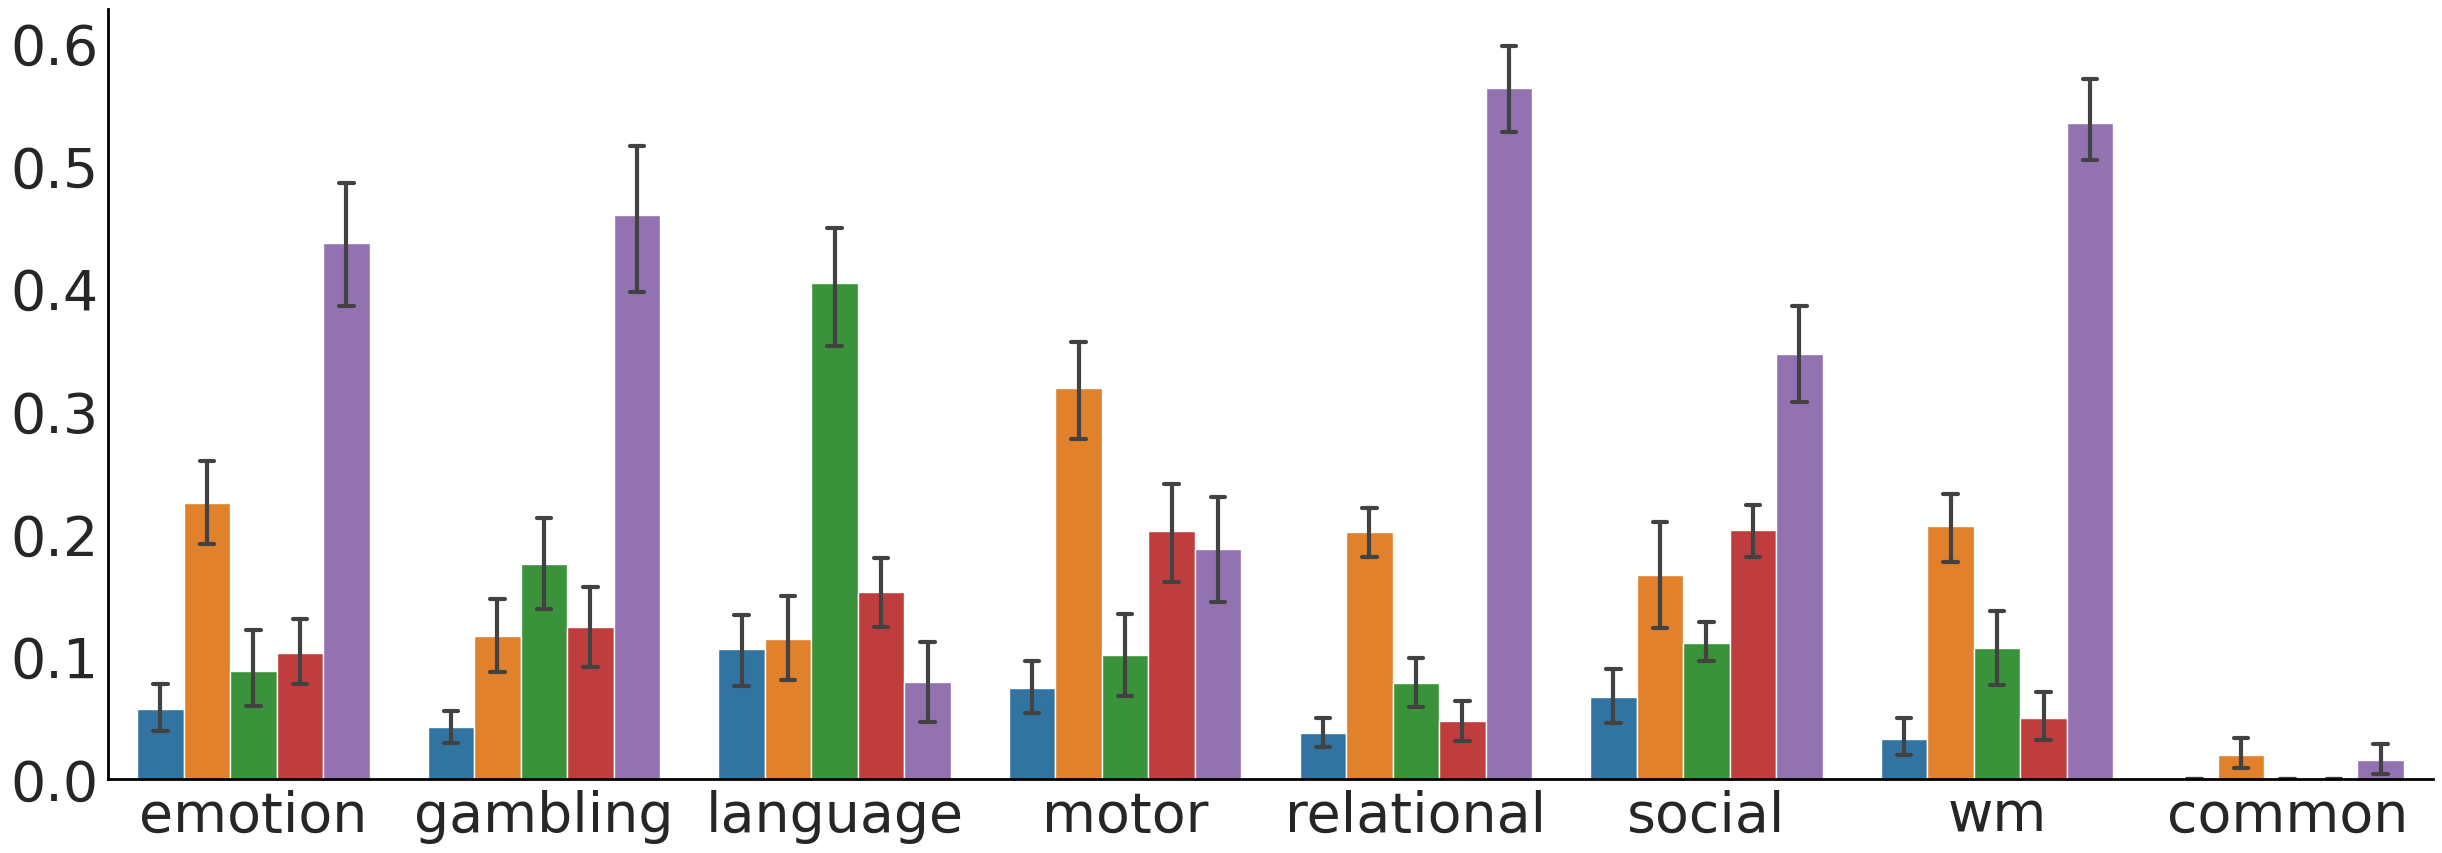

In [14]:
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
df.insert(loc=1, column='task', value=list(np.repeat(range(0,8), 6))*30)
df.insert(loc=2, column='lobe', value=list(np.arange(0,6))*240)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Frontal','Limbic','Temporal','Parietal','Occipital','Subcortical']
task_type = ['emotion','gambling','language','motor','relational','social','wm','common']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%8]
for i in np.arange(0,len(graph_value['lobe'])):
    graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%5]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['lobe'],errwidth=3,capsize=0.05,ci=95)
ax.get_legend().remove()
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
y_major_locator=MultipleLocator(0.1)
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/sixlob_supp/chcp_dk_top30_gyri.svg", dpi=300,format="svg")

In [17]:
# six lobe
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
percent = 20
allregions = 155
cortical_regions = 136
subcortical_regions = 19
all_lobe = []
data = os.listdir('/media/D/zephyr/functional_connectivity/CHCP/aparc/percent_0.15/Emotion')
data = [int(i[0:4]) for i in data]
data = np.array(sorted(data))
# data = np.arange(1,1008)
for random_state_num in range(1998,2004):
    five_fold = []
    kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
    for k,(train_index, test_index) in list(enumerate(kf.split(data))):
        all_task_all_sub = []
        for cls_num in range(7):
            one_task_all_sub = []
            for sub in data[test_index]:
                sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_chcp_vis/{}/{}/{}_node_{}_7class_original.npy'
                .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
            all_task_all_sub.append(one_task_all_sub)
        five_fold.append(all_task_all_sub)
    six_lobe = np.load('/media/D/zephyr/vit_155_155/tulunzhibiao/bigger_six_region_of_155_region.npy')
    one_k_lobe = []
    for k in range(5):
        one_fold_lobe = []
        one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
        for task_num in  range(7):
            top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            # top_node = [i for i in top_node if i %2==0 and i<=135] #sulci
            top_node = [i for i in top_node if i %2==1 and i<=135] #gyri
            # top_node = np.array([(i,i-1) for i in top_node if i %2==1 and i<=135 and i-1 in top_node]).reshape(-1)#both
            # top_node = [i for i in top_node if i %2==1 and i<=135 and i-1  not in top_node]#gyri domain
            # top_node = [i for i in top_node if i %2==0 and i<=135 and i+1  not in top_node]#sulci domain
            lobe = six_lobe[top_node]
            one_fold_lobe.append(top_node)
        one_k_lobe.append(one_fold_lobe)
    all_lobe.append(one_k_lobe)

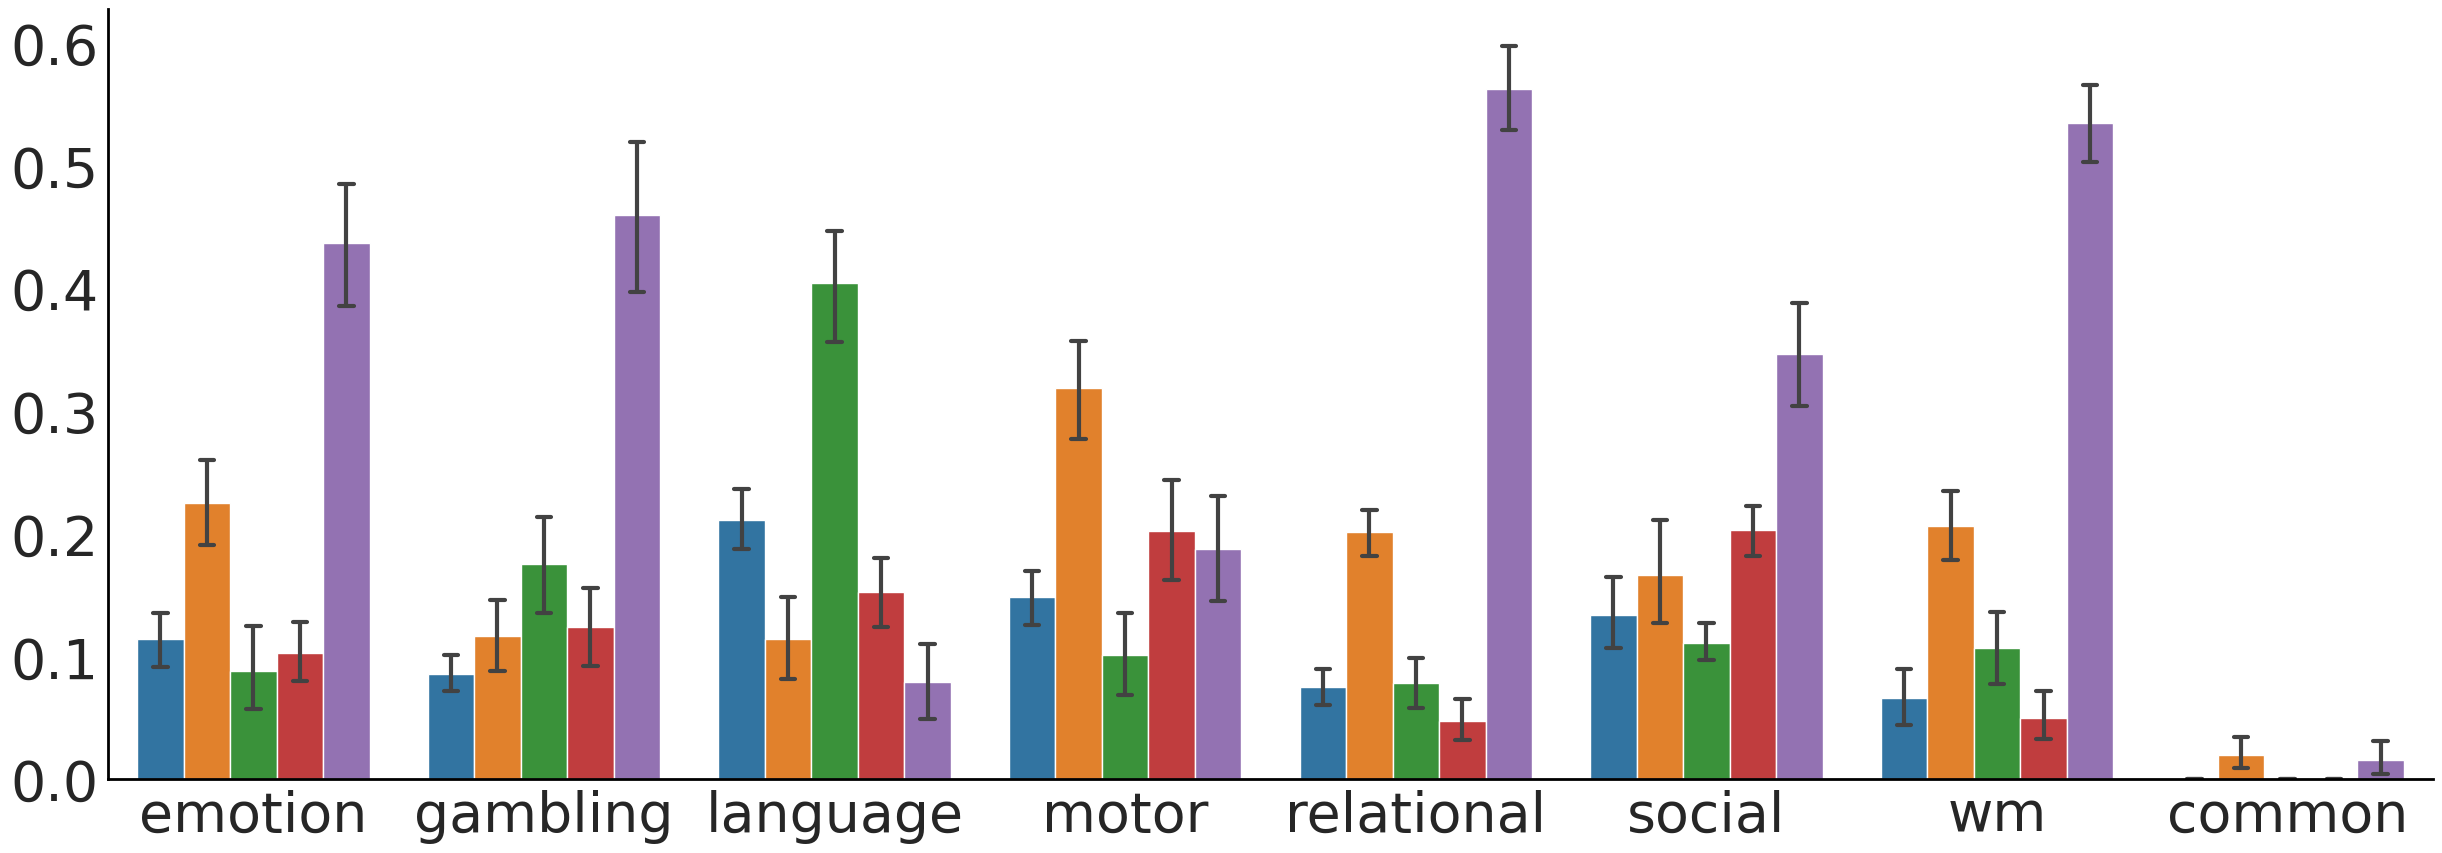

In [18]:
#标准化后的结果
uniqiu_value = []
for k in range(6):
    for j in range(5):
        comm = all_lobe[k][j][0]
        for task in range(7):
            comm = np.intersect1d(all_lobe[k][j][task],comm)
        if len(comm) == 0:
            comm_lobe = [0,0,0,0,0,0]
        else:
            comm_lobe = six_lobe[comm]
        lobe_value = [len([i for i in comm_lobe if i==1]),
        (40/24)*len([i for i in comm_lobe if i==2]),
        (40/28)*len([i for i in comm_lobe if i==3]),
        (40/24)*len([i for i in comm_lobe if i==4]),
        (40/20)*len([i for i in comm_lobe if i==5])]
        for task_ in range(7):
            all = [len([i for i in six_lobe[all_lobe[k][j][task_]] if i==1]),
            (40/24)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==2]),
            (40/28)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==3]),
            (40/24)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==4]),
            (40/20)*len([i for i in six_lobe[all_lobe[k][j][task_]] if i==5])]
            task_unique = np.array(all)-np.array(lobe_value)
            task_unique = np.divide(task_unique, sum(all))
            uniqiu_value.append(task_unique)      
        uniqiu_value.append(np.divide(lobe_value, sum(all)))
column = ['value']
df = pd.DataFrame(columns=column,data = np.array(uniqiu_value).reshape(-1))
df.insert(loc=1, column='task', value=list(np.repeat(range(0,8), 5))*30)
df.insert(loc=2, column='lobe', value=list(np.arange(0,5))*240)
sns.set_style("whitegrid", {'axes.grid' : False})
six_regions_name = ['Frontal','Limbic','Temporal','Parietal','Occipital']
task_type = ['emotion','gambling','language','motor','relational','social','wm','common']
fig,ax = plt.subplots(figsize=(30,10))                
graph_value = df
for i in np.arange(0,len(graph_value['task'])):
    graph_value['task'][i] = task_type[graph_value['task'][i]%8]
for i in np.arange(0,len(graph_value['lobe'])):
    graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%5]    
ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['lobe'],errwidth=3,capsize=0.05,ci = 95)
ax.get_legend().remove()
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
y_major_locator=MultipleLocator(0.1)
ax = plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/sixlob_supp/chcp_dk_top30_gyri.svg".format(percent), dpi=300,format="svg")

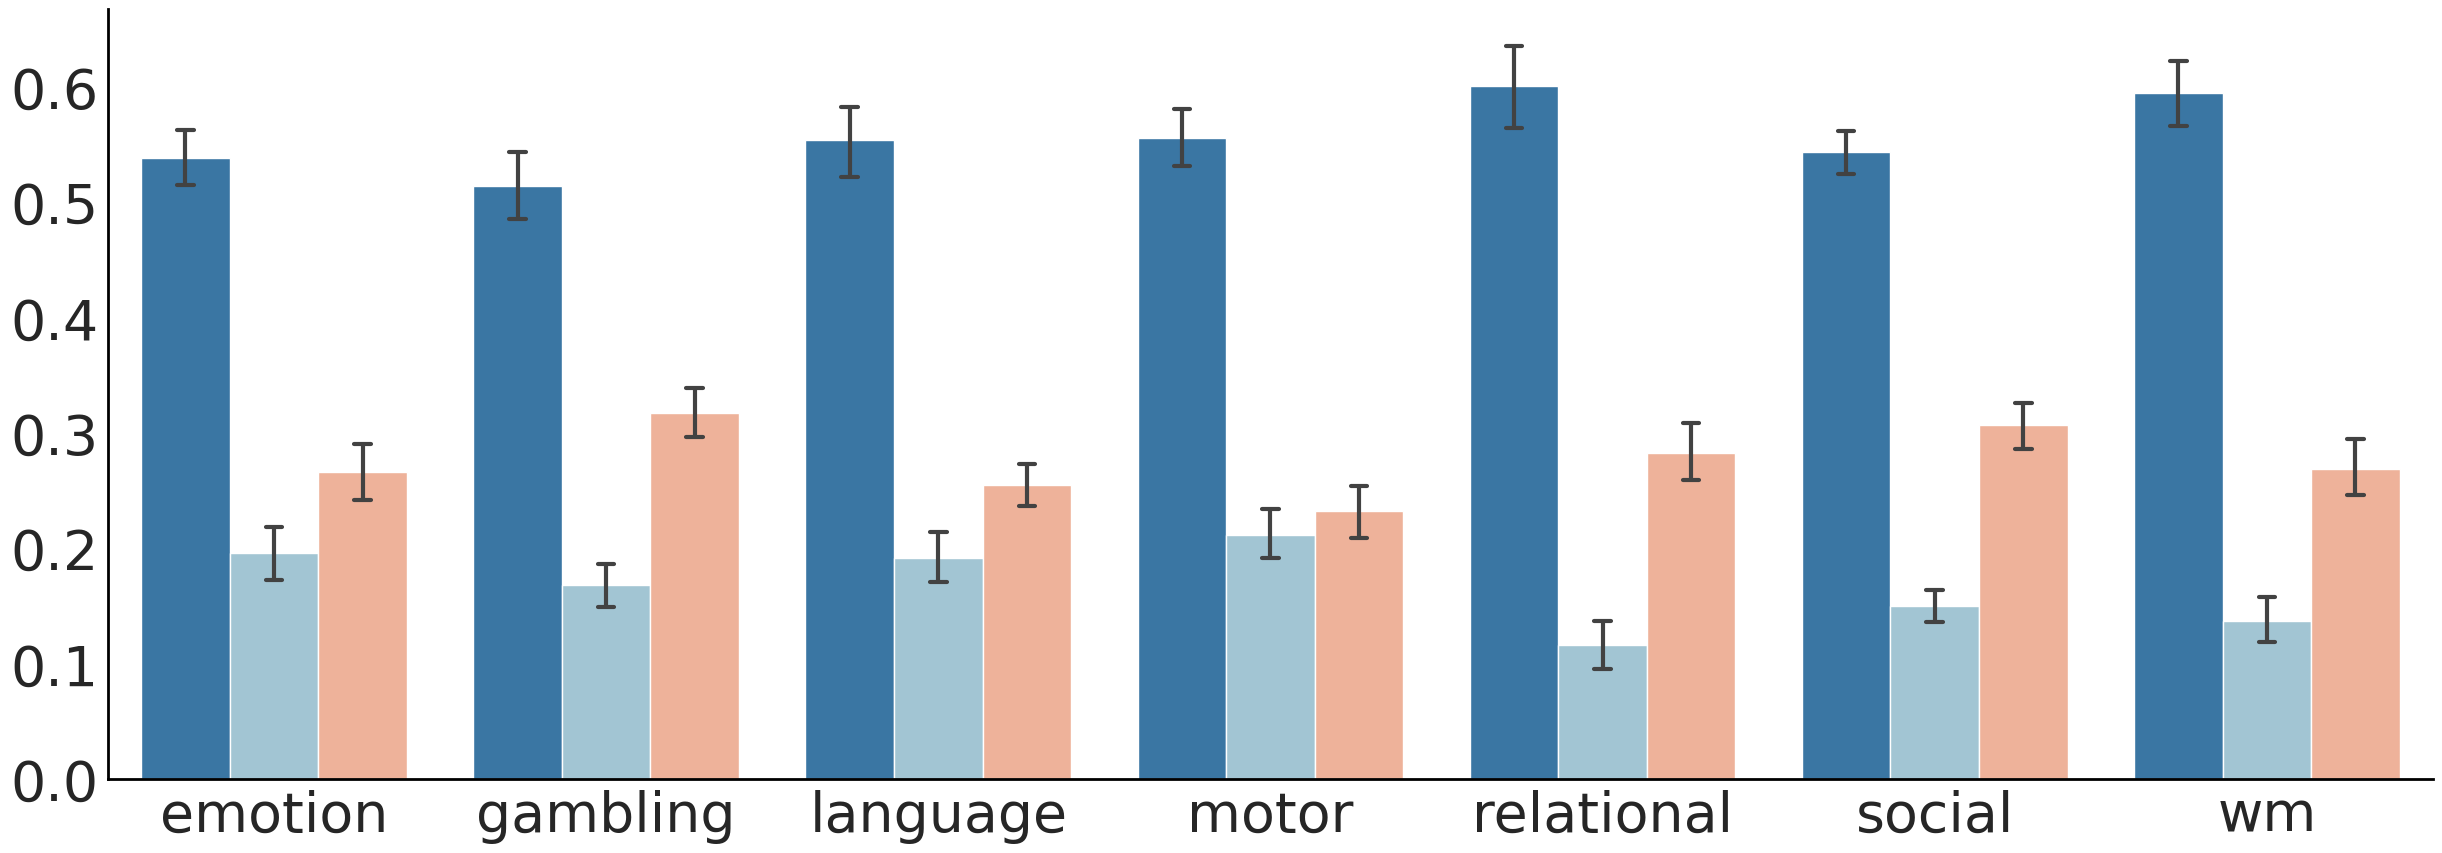

In [49]:
#共有的区域和独有的区域
CLS2IDX =  ['emotion','gambling','language','motor','relational','social','wm']
for percent in np.arange(20,21,5):

    # percent = 30
    all_lobe = []
    for random_state_num in range(1998,2004):
        data = np.arange(1,1008)
        five_fold = []
        kf=KFold(n_splits=5,shuffle=True,random_state=random_state_num)
        for k,(train_index, test_index) in list(enumerate(kf.split(data))):
            all_task_all_sub = []
            for cls_num in range(7):
                one_task_all_sub = []
                for sub in data[test_index]:
                    sub_node = np.load('/media/D/zephyr/vit_155_155/other_map/aparc_vis/{}/{}/{}_node_{}_7class_original.npy'
                    .format(percent,CLS2IDX[cls_num],sub,random_state_num))
                    one_task_all_sub.append((sub_node-sub_node.min())/(sub_node.max()-sub_node.min()))
                all_task_all_sub.append(one_task_all_sub)
            five_fold.append(all_task_all_sub)
        six_lobe = np.load('/media/D/zephyr/vit_155_155/tulunzhibiao/bigger_six_region_of_155_region.npy')
        one_k_lobe = []
        for k in range(5):
            one_fold_lobe = []
            one_fold_re = np.array(five_fold[k]).transpose((0,2,1))
            for task_num in  range(7):
                top_node = np.argsort(-np.sum(one_fold_re,2)[task_num])[0:46]
            # top_node = [i for i in top_node if i %2==0 and i<=135] #sulci
            # top_node = [i for i in top_node if i %2==1 and i<=135] #gyri
                top_node1 = np.array([(i,i-1) for i in top_node if i %2==1 and i<=135 and i-1 in top_node]).reshape(-1)#both
                top_node2 = [i for i in top_node if i %2==1 and i<=135 and i-1  not in top_node]#gyri domain
                top_node3 = [i for i in top_node if i %2==0 and i<=135 and i+1  not in top_node]#sulci domain
                # lobe = six_lobe[top_node]
                one_fold_lobe.append(np.divide([len(top_node1),len(top_node2),len(top_node3)], sum([len(top_node1),len(top_node2),len(top_node3)])))
            one_k_lobe.append(one_fold_lobe)
        all_lobe.append(one_k_lobe)
    

    flatui = ["#2878B5", "#9AC9DB","#FCAC8C"  ]
    column = ['value']
    df = pd.DataFrame(columns=column,data = np.array(all_lobe).reshape(-1))
    df.insert(loc=1, column='task', value=list(np.repeat(range(0,7), 3))*30)
    df.insert(loc=2, column='lobe', value=list(np.arange(0,3))*210)
    sns.set_style("whitegrid", {'axes.grid' : False})
    six_regions_name = ['both','gyri','sulci','Parietal','Occipital']
    task_type = ['emotion','gambling','language','motor','relational','social','wm','common']
    fig,ax = plt.subplots(figsize=(30,10))                
    graph_value = df
    for i in np.arange(0,len(graph_value['task'])):
        graph_value['task'][i] = task_type[graph_value['task'][i]%7]
    for i in np.arange(0,len(graph_value['lobe'])):
        graph_value['lobe'][i] = six_regions_name[graph_value['lobe'][i]%3]    
    ax = sns.barplot( x=graph_value["task"],y=graph_value["value"],hue=graph_value['lobe'],errwidth=3,capsize=0.05,ci =95,palette=flatui)
    ax.get_legend().remove()
    plt.ylabel('',fontsize=40)
    plt.xlabel('',fontsize=30,weight='bold')
    plt.yticks(fontsize=40)
    plt.xticks(fontsize=40)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    # plt.xticks(rotation=30)
    plt.savefig("/media/D/zephyr/vit_155_155/picture_new/hcp/815/control_{}_GYRI_SULCI_BOTH.svg".format(percent), dpi=300,format="svg")

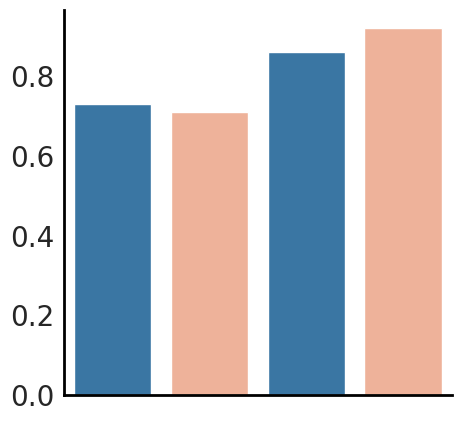

In [29]:
flatui = ["#2878B5", "#FCAC8C","#2878B5","#FCAC8C"  ]
column = ['acc']
df = pd.DataFrame(columns=column,data = [0.73,0.71,0.86,0.92])
df.insert(loc=1, column='task', value=['DK1','DK2','Schaefer1','Schaefer2'])
fig,ax = plt.subplots(figsize=(5,5))
ax = sns.barplot( x=df["task"],y=df["acc"],capsize=0.05,palette=flatui)
plt.ylabel('',fontsize=40)
plt.xlabel('',fontsize=30,weight='bold')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.set_xticklabels([])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig("/media/D/zephyr/vit_155_155/picture_new/hcp/815/crossval_{}.svg".format(percent), dpi=300,format="svg")